In the following code, I would like to summarize the core of two of my research projects, both in the theme of network science
In the first section, I analyze the network of public transportation in Budapest using GTFS data
In the second section, I perform the 15-minute analysis, which aims to provide an upper bound for decision-makers on how large an area it can cover from one stop

Importing the packages

In [1]:
import geopandas as gpd
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO
import tqdm as tqdm
from scipy.spatial.distance import pdist, squareform
import matplotlib.cm as cm 
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from math import radians, sin, cos, sqrt, atan2
from networkx.algorithms.community import greedy_modularity_communities
import pickle
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import networkx as nx
import community 
from joblib import Parallel, delayed
import seaborn as sns

/home/mizsakma/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/mizsakma/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
df_common = pd.DataFrame()
for i in range(1, 8): 
    file_path = f"/mnt/common-ssd/mizsakma/tkom-data/gtfs_puskas/gtfs/gtfs_whole_week/gtfs ({i})/stops.txt"
    with open(file_path, 'r') as file:
        file_contents = file.read()
    df = pd.read_csv(StringIO(file_contents), sep=",")
    df_common = pd.concat([df_common, df], ignore_index=True)
    df_common = df_common.drop_duplicates()

# Here, I create one big DataFrame containing all unique stops occurring across any of the days

In [3]:
myprojection_latlong_2 = 4326
stops = gpd.GeoDataFrame(geometry = gpd.points_from_xy(df_common["stop_lon"], df_common["stop_lat"]), crs = myprojection_latlong_2)

def calculate_geodesic_distance(point1, point2):
    return geodesic((point1.y, point1.x), (point2.y, point2.x)).meters

stops = gpd.GeoDataFrame(geometry=stops["geometry"])
stops.crs = myprojection_latlong_2
stops = stops.to_crs(myprojection_latlong_2)

num_points = len(stops)
geodesic_distance_matrix = np.zeros((num_points, num_points))

# calculating geodesic distances between pairs of points represented by longitude and latitude coordinates.
#The distance matrix initialized here will be populated with actual distance values in subsequent step

In [4]:
try:
    puskas_matrix = np.load("/mnt/common-ssd/mizsakma/tkom-data/gtfs_puskas/gtfs/gtfs_puskas/puskas_week.npy") #loading the distance matrix if exists
except FileNotFoundError:
    for i in tqdm(range(num_points)):
        for j in range(num_points):
            if i != j:
                distance = calculate_geodesic_distance(stops.iloc[i].geometry, stops.iloc[j].geometry)
                geodesic_distance_matrix[i, j] = distance
    np.save("puskas_week.npy", geodesic_distance_matrix)

In [5]:
#hierarchical clustering on the distance matrix 

linkage_matrix = linkage(puskas_matrix, method="complete")
dist_threshold = 8500  #approximately 150m
clusters = fcluster(linkage_matrix, dist_threshold, criterion="distance")
df_common["clust"] = clusters

/tmp/ipykernel_1064404/1545104921.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(puskas_matrix, method="complete")


In [6]:
stop_clusters = df_common.groupby('stop_name')['clust'].unique()
stop_clusters_count = stop_clusters.apply(len)
stop_clusters_count_df = stop_clusters_count.reset_index()
stop_clusters_count_df.columns = ['stop_name', 'num_clusters']

# Determine how many distinct clusters are associated with each stop in the transportation network. It is necessary because accurately creating nodes is essential for a working network

In [7]:
df_common_2 = df_common[df_common['stop_name'].str.endswith(('M', 'H'))]
clust_names_2 = set(df_common_2['stop_name'])
clust_names_2.add('Haller utca / Soroksári út')
clust_names_2 = list(clust_names_2)
clust_names_2


#However in the case of metros and and the bigger squares which we would like to consider as stop the 150m treshold is not enough. 
#But luckily we can do it automatically, because in the case of  and hév (literally metro but it has an other name in hungarian) at each stop there is an M or a H.
#For example in the case of Örs Vezér tere M+H the maximum distance between two stops is 500 meters, while both of them is called Örs vezér tere M+H.

['Blaha Lujza tér M',
 'Kén utca H',
 'Bajza utca M',
 'Szabadságtelep H',
 'Hősök tere M',
 'Pomáz H',
 'Margit híd, budai hídfő H',
 'Kőbánya-Kispest M',
 'Bikás park M',
 'Semmelweis Klinikák M',
 'Torontál utca H',
 'Bajcsy-Zsilinszky út M',
 'Szigetszentmiklós H',
 'Gyöngyösi utca M',
 'Gödöllő H',
 'Müpa - Nemzeti Színház H',
 'Kossuth Lajos tér M',
 'Kálvin tér M',
 'Szent Gellért tér - Műegyetem M',
 'Békásmegyer H',
 'Rákosfalva H',
 'Pesterzsébet felső H',
 'Déli pályaudvar M',
 'Kelenföld vasútállomás M',
 'Fővám tér M',
 'Nagyicce H',
 'Kvassay híd H',
 'Kistarcsa H',
 'Mátyásföld, Imre utca H',
 'Soroksár felső H',
 'Boráros tér H',
 'Szentjakab H',
 'Aquincum H',
 'Karácsony Sándor utca H',
 'Soroksár, Hősök tere H',
 'Puskás Ferenc Stadion M',
 'Tököl H',
 'Nyugati pályaudvar M',
 'Újbuda-központ M',
 'Gödöllő, Palotakert H',
 'Deák Ferenc tér M',
 'Kerepes H',
 'Arany János utca M',
 'Ferenciek tere M',
 'Keleti pályaudvar M',
 'Oktogon M',
 'Dózsa György út M',
 'Mille

In [8]:
for i in clust_names_2:
        filtered_df = df_common[df_common['stop_name'] == i]
        unique_clusters = filtered_df['clust'].unique()
        if len(unique_clusters) >= 2:
            same = unique_clusters[:-1]
            clust_num = unique_clusters[-1]
            df_common.loc[df_common['clust'].isin(same), 'clust'] = clust_num

Distance within clusters

In [9]:
def calculate_geodesic_distance(point1, point2):
    latitude1, longitude1 = point1[0], point1[1]
    latitude2, longitude2 = point2[0], point2[1]
    return geodesic((latitude1, longitude1), (latitude2, longitude2)).meters

In [10]:
cluster_distances = []

for cluster_id, group in tqdm(df_common.groupby('clust')):
    coordinates = group[['stop_lat', 'stop_lon']].values  
    pairwise_distances = pdist(coordinates, metric=calculate_geodesic_distance)
    if len(pairwise_distances) > 0:
        distance_matrix = squareform(pairwise_distances)
        max_distance = distance_matrix.max()
        cluster_distances.append((cluster_id, max_distance))
    else:
        cluster_distances.append((cluster_id, 0))
cluster_distances_df = pd.DataFrame(cluster_distances, columns=['clust', 'max_distance'])
df_common = pd.merge(df_common, cluster_distances_df, on = 'clust')

  0%|          | 0/2340 [00:00<?, ?it/s]

100%|██████████| 2340/2340 [00:03<00:00, 649.89it/s] 


In [11]:
df_common.sort_values('clust')

,stop_id,stop_name,stop_lat,stop_lon,stop_code,location_type,parent_station,wheelchair_boarding,stop_direction,clust,max_distance
2566,F04632,Szigetszentmárton-Szigetújfalu,47.228459,18.945901,F04632,NaN,CSF04632,2.0,-12.0,1,121.585654
2564,CSF04632,Szigetszentmárton-Szigetújfalu,47.227924,18.946067,CSF04632,1.0,NaN,NaN,NaN,1,121.585654
2565,F04631,Szigetszentmárton-Szigetújfalu,47.227389,18.946233,F04631,NaN,CSF04632,2.0,166.0,1,121.585654
2567,CSF04634,Horgásztanyák,47.213582,18.952953,CSF04634,1.0,NaN,NaN,NaN,2,62.126198
2568,F04634,Horgásztanyák,47.214135,18.953071,F04634,NaN,CSF04634,2.0,2.0,2,62.126198
...,...,...,...,...,...,...,...,...,...,...,...
1123,009014,EGIS-telep (Szentjakab H),47.592911,19.284773,NaN,NaN,NaN,2.0,-61.0,2427,76.489069
1140,F04669,Mogyoród,47.595986,19.271649,F04669,NaN,CSF04668,2.0,177.0,2428,48.781589
1139,009022,Mogyoród H,47.595557,19.271513,NaN,NaN,NaN,2.0,-51.0,2428,48.781589
2579,CSF04668,Mogyoród,47.596508,19.271751,CSF04668,1.0,NaN,NaN,NaN,2429,58.431775


In [12]:
df_2 = df_common.sort_values('clust').copy()
df_2 = df_2.drop_duplicates()
df_2['quant'] = df_2.groupby('clust')['clust'].transform('count')
df_2.loc[df_2['location_type'] == 1.0, 'parent_station'] = df_2['stop_id']

df_2_b = df_2[df_2['quant'] > 1].copy()
df_2_a = df_2[df_2['quant'] <= 1].copy()

# df_2_b part
df_2_b = df_2_b.sort_values('clust')

df_2_b['parent_station'] = df_2_b['parent_station'].astype(str)
max_parent_by_clust = df_2_b.groupby('clust')['parent_station'].transform(lambda x: np.where(x != '', x, x.max()))
df_2_b['parent_station'] = max_parent_by_clust

grouped = df_2_b.groupby('clust')
max_parent_by_clust = grouped['parent_station'].transform(lambda x: np.where(x.notna(), x, x.max()))

df_2_b['parent_station'] = np.where(
    (df_2_b['parent_station'] == 'nan') & (df_2_b['quant'] > 1),
    df_2_b.groupby('clust')['stop_id'].transform(lambda x: x.iloc[0]),
    max_parent_by_clust
)

#df_2_a part -> quant with the value of 1, or without value
lonely_stops = (df_2_a['quant'] == 1) & (df_2_a['parent_station'].isna())
df_2_a.loc[lonely_stops, 'parent_station'] = df_2_a.loc[lonely_stops, 'stop_id']

#Unite
df_2 = pd.concat([df_2_a, df_2_b], ignore_index=True)
df_2['parent_station'] = df_2.groupby('clust')['parent_station'].transform('first')
df_2['stop_lon'] = df_2.groupby('parent_station')['stop_lon'].transform('first')
df_2['stop_lat'] = df_2.groupby('parent_station')['stop_lat'].transform('first')
df_2 = df_2.drop_duplicates()
df = df_2.copy()
df['stop_id'] = df['parent_station']
#Here I have to operform some data manipulation in order to be unified parent_sation at every cluster in every single case

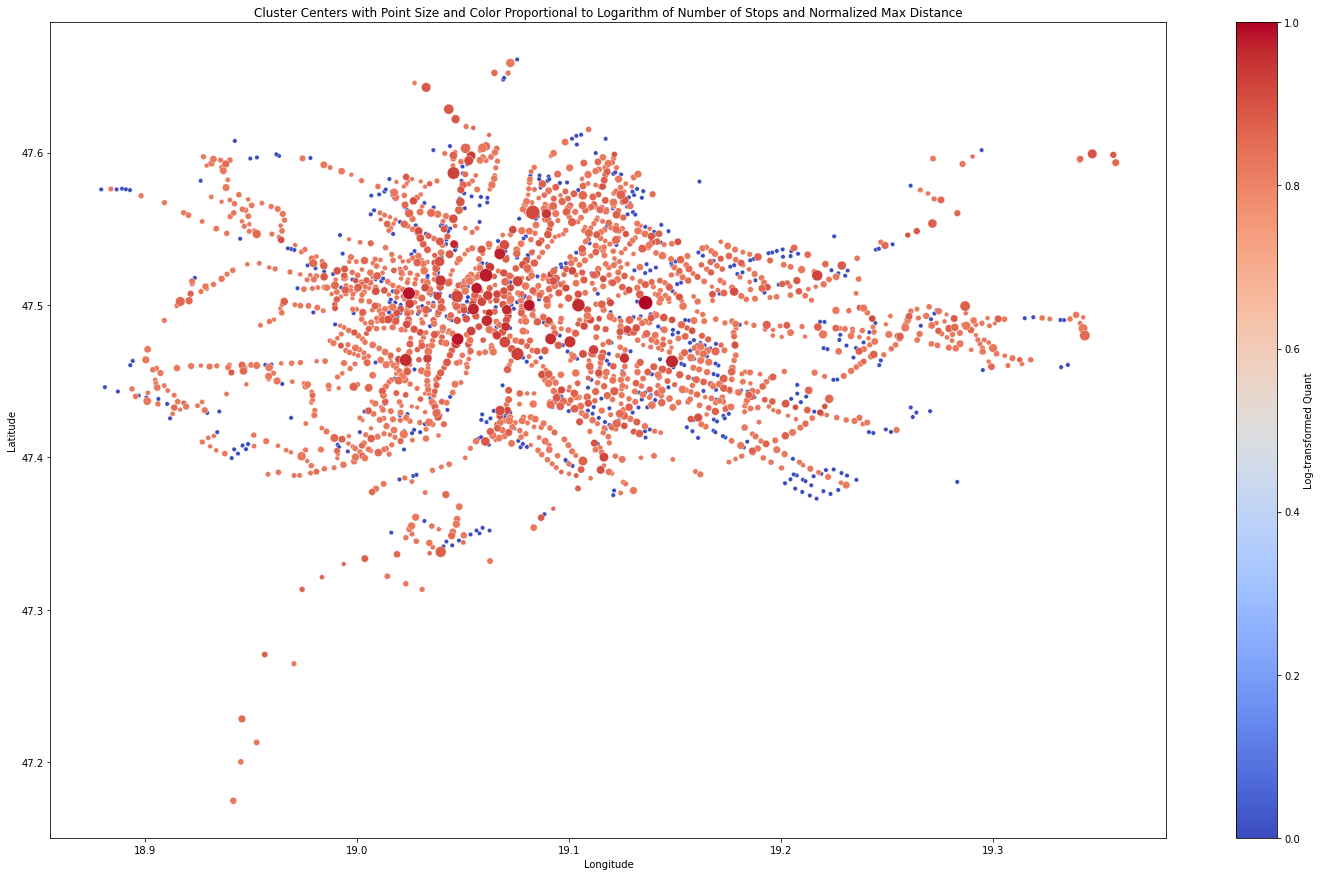

In [24]:
df_2_filtered_log = df_2.copy()
df_2_filtered_log.loc[df_2_filtered_log['max_distance'] == 0, 'max_distance'] = 1
df_2_filtered_log['quant'] = np.log(df_2_filtered_log['quant'] + 1e-10)  

cluster_centers = df_2_filtered_log.groupby('clust').agg({
    'stop_lat': 'mean',
    'stop_lon': 'mean',
    'quant': 'sum',
    'max_distance': 'max'  
}).reset_index()

max_distance_min = cluster_centers['max_distance'].min()
max_distance_max = cluster_centers['max_distance'].max()
cluster_centers['max_distance_normalized'] = (cluster_centers['max_distance'] - max_distance_min) / (max_distance_max - max_distance_min)

cluster_centers = cluster_centers.sort_values(by='max_distance_normalized', ascending=True)

plt.figure(figsize=(25, 15))  
scatter = sns.scatterplot(
    x='stop_lon',
    y='stop_lat',
    size=cluster_centers['max_distance_normalized'], 
    hue=np.log(cluster_centers['quant']), 
    palette='coolwarm', 
    data=cluster_centers,
    sizes=(20, 200),  
    legend=False,
    zorder=2  
)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cluster Centers with Point Size and Color Proportional to Logarithm of Number of Stops and Normalized Max Distance')

sm = cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=cluster_centers['max_distance_normalized'].min(), vmax=cluster_centers['max_distance_normalized'].max()))
sm.set_array([])

cbar = plt.colorbar(sm, label='Log-transformed Quant', ax=scatter)

plt.savefig('cluster_map.png')

plt.show()

In [14]:
list_of_netwroks_own_w = []
list_of_network_day = []
list_of_weights = []
list_of_network_time = []

pure_stop_times_next_day = pd.DataFrame()

for days in tqdm(range(1,8)):

    file_path = f"/mnt/common-ssd/mizsakma/tkom-data/gtfs_puskas/gtfs/gtfs_whole_week/gtfs ({days})"
    
    pure_stop_times = pd.read_csv(file_path + "/stop_times.txt", sep=",")
    
    routes = pd.read_csv(file_path + "/routes.txt", sep=",")

    trips = pd.read_csv(file_path + "/trips.txt", sep=",")

    pure_stop_times = pure_stop_times.merge(df_2[['stop_id', 'clust', 'parent_station', 'stop_name']], on='stop_id', how='left')
    pure_stop_times.loc[pure_stop_times['parent_station'].notna(), 'stop_id'] = pure_stop_times['parent_station']
    pure_stop_times.loc['stop_id'] = pure_stop_times['parent_station']

    routes = routes[['route_id', 'route_type']]
    trips = trips[['route_id', 'trip_id', 'service_id']]  
    trips = pd.merge(trips, routes, on='route_id', how='right')
    pure_stop_times = pure_stop_times.merge(trips[['trip_id', 'route_id', 'route_type', 'service_id']], on='trip_id', how='left')

    pure_stop_times['stop_id_to'] = pure_stop_times.groupby((['trip_id', 'service_id', 'route_id', 'route_type']))['stop_id'].shift(-1)
    pure_stop_times['arrival_time_stop_to'] = pure_stop_times.groupby(['trip_id', 'service_id', 'route_id', 'route_type'])['arrival_time'].shift(-1)
    pure_stop_times['distance_travaled'] = pure_stop_times.groupby(['trip_id', 'service_id', 'route_id', 'route_type'])['shape_dist_traveled'].shift(-1)

    #deleting the terminals and loops
    pure_stop_times = pure_stop_times[pure_stop_times['arrival_time_stop_to'].notna()]
    pure_stop_times = pure_stop_times[pure_stop_times['stop_id'] != pure_stop_times['stop_id_to']]

    pure_stop_times['arrival_hour'] = pure_stop_times['arrival_time_stop_to'].apply(lambda x: int(x.split(':')[0]))
    pure_stop_times['arrival_minute'] = pure_stop_times['arrival_time_stop_to'].apply(lambda x: int(x.split(':')[1]))
    pure_stop_times['arrival_second'] = pure_stop_times['arrival_time_stop_to'].apply(lambda x: int(x.split(':')[2]))

    pure_stop_times['departure_hour'] = pure_stop_times['departure_time'].apply(lambda x: int(x.split(':')[0]))
    pure_stop_times['departure_minute'] = pure_stop_times['departure_time'].apply(lambda x: int(x.split(':')[1]))
    pure_stop_times['departure_second'] = pure_stop_times['departure_time'].apply(lambda x: int(x.split(':')[2]))
    
    pure_stop_times['arrival_time'] = pd.to_datetime({
        'year': 2020,  
        'month': 9,   
        'day': 20 + days,      
        'hour': pure_stop_times['arrival_hour'],
        'minute': pure_stop_times['arrival_minute'],
        'second': pure_stop_times['arrival_second'] })

    pure_stop_times['departure_time'] = pd.to_datetime({
        'year':2020,
        'month':9,
        'day': 20 + days,
        'hour':pure_stop_times['departure_hour'],
        'minute':pure_stop_times['departure_minute'],
        'second':pure_stop_times['departure_second']
    })

    pure_stop_times = pd.concat([pure_stop_times, pure_stop_times_next_day], ignore_index=True)
    pure_stop_times_next_day = pure_stop_times[pure_stop_times['departure_hour'] >= 24].copy()
    pure_stop_times_next_day['departure_hour'] = pure_stop_times_next_day['departure_hour'] % 24
    pure_stop_times = pure_stop_times[pure_stop_times['departure_hour'] < 24]
    
    pure_stop_times['hour_frequency'] = pure_stop_times.groupby(['stop_id', 'stop_id_to', 'departure_hour']).transform('size')
    pure_stop_times['travel_duration'] = pure_stop_times['arrival_time'] - pure_stop_times['departure_time']
    pure_stop_times['travel_duration'] = pure_stop_times['travel_duration'].dt.total_seconds().astype(int)
    pure_stop_times['distance_travaled'] = pure_stop_times['distance_travaled'] - pure_stop_times['shape_dist_traveled']

    pure_stop_times = pure_stop_times[['trip_id', 'stop_id', 'stop_id_to','stop_sequence', 'route_id', 'route_type', 'travel_duration', 'distance_travaled', 'departure_hour', 'hour_frequency', 'departure_time', 'arrival_time']]
    
    pure_stop_times['weight_own'] = pure_stop_times['hour_frequency'] * (pure_stop_times['travel_duration'] + 1 / (pure_stop_times['distance_travaled'] + 1))
    pure_stop_times['weight_freq'] = pure_stop_times['hour_frequency']
    pure_stop_times['weight_time'] = pure_stop_times.groupby(['stop_id', 'stop_id_to', 'departure_hour'])['travel_duration'].transform('mean')
    pure_stop_times['weight_dis'] = pure_stop_times.groupby(['stop_id', 'stop_id_to', 'departure_hour'])['distance_travaled'].transform('mean')

    list_of_weights.append(pure_stop_times)

    network_day = nx.DiGraph()
    network_day = nx.from_pandas_edgelist(
    pure_stop_times,
    source='stop_id',
    target='stop_id_to',
    ) 
    list_of_network_day.append(network_day)
        
    for hour in range(24):
        pure_stop_times_network = pure_stop_times[pure_stop_times['departure_hour'] == hour]
        network_own = nx.from_pandas_edgelist(
            pure_stop_times_network,
            source='stop_id',
            target='stop_id_to',
            edge_attr=['weight_own'],
            create_using=nx.DiGraph()
        )
        list_of_netwroks_own_w.append(network_own)

        network = nx.from_pandas_edgelist(
            pure_stop_times_network,
            source='stop_id',
            target = 'stop_id_to',
            edge_attr=['weight_time'],
            create_using=nx.DiGraph()
        )
        list_of_network_time.append(network)

  0%|          | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_1064404/3183413904.py:16: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  trips = pd.read_csv(file_path + "/trips.txt", sep=",")
 14%|█▍        | 1/7 [01:10<07:03, 70.58s/it]/tmp/ipykernel_1064404/3183413904.py:16: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  trips = pd.read_csv(file_path + "/trips.txt", sep=",")
 29%|██▊       | 2/7 [02:21<05:54, 70.93s/it]/tmp/ipykernel_1064404/3183413904.py:16: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  trips = pd.read_csv(file_path + "/trips.txt", sep=",")
 43%|████▎     | 3/7 [03:35<04:49, 72.39s/it]/tmp/ipykernel_1064404/3183413904.py:12: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  pure_stop_times = pd.read_csv(file_path + "/stop_times.txt", sep=",")
/tmp/ipykernel_1064404/3183413904.py:16: DtypeWarning: Col

Trying to create a new fully connected network, to know where shall I cluster more

Calculating the results

In [15]:
with open("list_of_network_time.pkl", "wb") as f:
    pickle.dump(list_of_network_time, f)

with open("list_of_netwroks_own_w.pkl", "wb") as f:
    pickle.dump(list_of_netwroks_own_w, f)

In [16]:
def compute_metrics(network, day, hour):
    num_of_edges = nx.number_of_edges(network)
    num_of_nodes = nx.number_of_nodes(network)
    avg_clus = nx.average_clustering(network, weight='weight')
    betweenness_centrality = nx.betweenness_centrality(network, weight='weight')
    mean_betweenness = sum(betweenness_centrality.values()) / len(betweenness_centrality)
    density_value = nx.density(network)
    beta_index_value = num_of_edges / num_of_nodes

    return {
        'num_of_edges': num_of_edges,
        'num_of_nodes': num_of_nodes,
        'avg_clustering': avg_clus,
        'mean_betweenness': mean_betweenness,
        'density': density_value,
        'beta_index': beta_index_value}

days = [day for day in range(1, 8) for _ in range(24)]
hours = [hour for _ in range(7) for hour in range(24)]

In [17]:
try:
    df_results_own = pd.read_csv("list_of_netwroks_own_w_3.csv")
except FileNotFoundError:

    metrics_results = []
    with ProcessPoolExecutor() as executor:
        results = list(tqdm(executor.map(compute_metrics, list_of_netwroks_own_w, days, hours), total=len(list_of_netwroks_own_w)))

    metrics_results.extend(results)
    df_results_own = pd.DataFrame(metrics_results)
    df_results_own.to_csv("list_of_netwroks_own_w_3.csv", index=False)

In [18]:
try:
    df_results_time = pd.read_csv("list_of_netwroks_time_3.csv")
except FileNotFoundError:

    metrics_results_3 = []
    with ProcessPoolExecutor() as executor:
        results_3 = list(tqdm(executor.map(compute_metrics, list_of_network_time, days, hours), total=len(list_of_network_time)))

    metrics_results.extend(results_3)
    df_results_time = pd.DataFrame(metrics_results_3)
    df_results_time.to_csv("list_of_netwroks_time_3.csv", index=False)

In [20]:
df_results_own['day'] = days
df_results_own['hour'] = hours
df_results_time['day'] = days
df_results_time['hour'] = hours

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


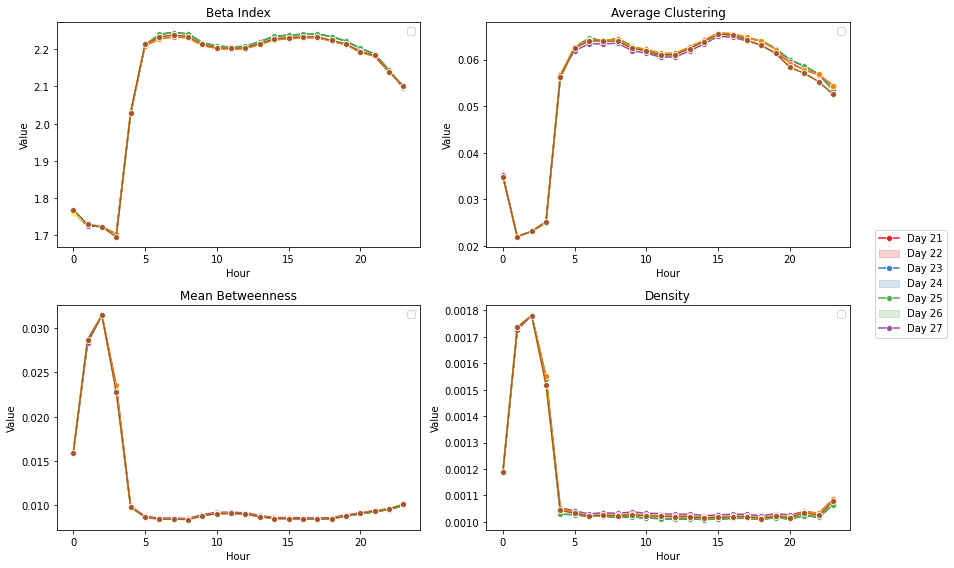

In [21]:
columns_to_plot = ['global_efficiency', 'avg_clustering', 'mean_betweenness', 'density', 'beta_index']
df_final = df_results_own[5:]

unique_days = df_final['day'].unique()

sns.set_palette("Set1", n_colors=len(unique_days))  

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for day in unique_days:
    df_day = df_final[df_final['day'] == day]

    sns.lineplot(x='hour', y='beta_index', data=df_day, marker='o', linestyle='-', ax=axes[0, 0])

    sns.lineplot(x='hour', y='avg_clustering', data=df_day, marker='o', linestyle='-', ax=axes[0, 1])

    sns.lineplot(x='hour', y='mean_betweenness', data=df_day, marker='o', linestyle='-', ax=axes[1, 0])

    sns.lineplot(x='hour', y='density', data=df_day, marker='o', linestyle='-', ax=axes[1, 1])

axes[0, 0].set_title('Beta Index')
axes[0, 1].set_title('Average Clustering')
axes[1, 0].set_title('Mean Betweenness')
axes[1, 1].set_title('Density')

for ax in axes.flat:
    ax.set_xlabel('Hour')
    ax.set_ylabel('Value')
    ax.legend(loc='upper right')

fig.legend(labels=[f'Day {day + 20}' for day in unique_days], loc='center right', bbox_to_anchor=(1.1, 0.5), borderaxespad=0.)

plt.tight_layout()
plt.show()

In [22]:
weights = pd.concat(list_of_weights, axis=0, ignore_index=True)
weights['day'] = weights['departure_time'].dt.day
weights = weights[['stop_id', 'stop_id_to', 'departure_hour', 'weight_own', 'weight_freq', 'weight_dis', 'weight_time', 'day']]
# Perform groupby and aggregation, then reset the index
weights = weights.drop_duplicates()
weights = weights.groupby(['departure_hour', 'day']).agg({
    'weight_own': 'sum',
    'weight_freq': 'sum',
    'weight_time': 'sum',
    'weight_dis': 'sum'
}).reset_index()

weights = weights.sort_values(by=(['day', 'departure_hour']))[2:]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


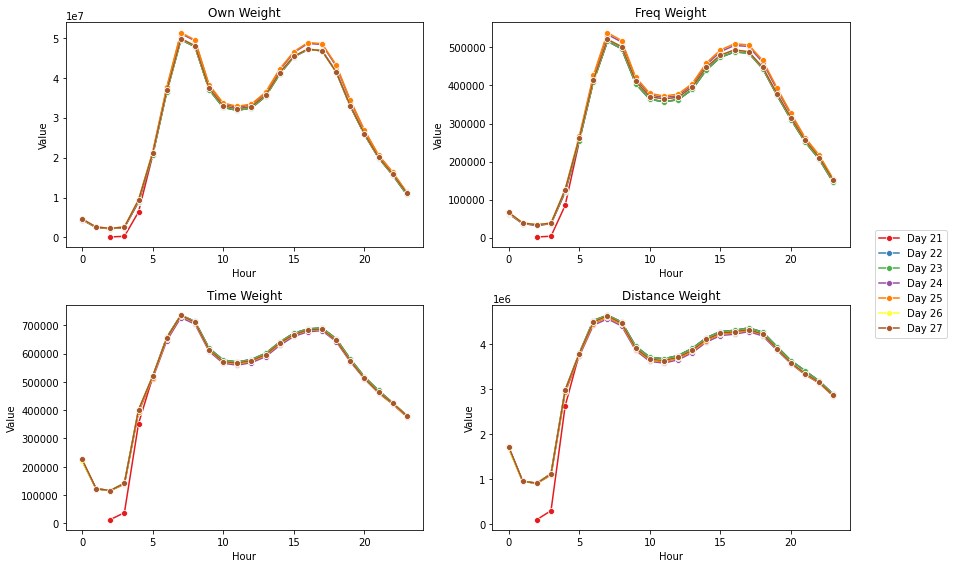

In [23]:
columns_to_plot = ['weight_own', 'weight_freq', 'weight_time', 'weight_dis']
df_final = weights  
unique_days = df_final['day'].unique()
sns.set_palette("Set1", n_colors=len(unique_days))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for day in unique_days:
    df_day = df_final[df_final['day'] == day]

    sns.lineplot(x='departure_hour', y='weight_own', data=df_day, marker='o', linestyle='-', ax=axes[0, 0], label=f'Day {day}')
    sns.lineplot(x='departure_hour', y='weight_freq', data=df_day, marker='o', linestyle='-', ax=axes[0, 1])
    sns.lineplot(x='departure_hour', y='weight_time', data=df_day, marker='o', linestyle='-', ax=axes[1, 0])
    sns.lineplot(x='departure_hour', y='weight_dis', data=df_day, marker='o', linestyle='-', ax=axes[1, 1])

axes[0, 0].set_title('Own Weight')
axes[0, 1].set_title('Freq Weight')
axes[1, 0].set_title('Time Weight')
axes[1, 1].set_title('Distance Weight')

for ax in axes.flat:
    ax.set_xlabel('Hour')
    ax.set_ylabel('Value')
    ax.legend().remove()  

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5), borderaxespad=0.)

plt.tight_layout()
plt.savefig('puskas_week_weights.png', bbox_inches='tight')
plt.show()

Concept of 15 min city - public transportation using DFS approach

In [25]:
def keeping_largest_connected(network_list):
    for index, network in enumerate(network_list):
        if not nx.is_connected(network):
            largest_cc = max(nx.connected_components(network), key=len)
            network_list[index] = network.subgraph(largest_cc)

In [27]:
list_of_network_time_league = list_of_network_time[72:96]

1481

If changing a vehicle counts

In [33]:
#With two minute chages

edge_list = []

def dfs_paths_with_changes(network, df, initial_node, current_path=None, current_weight=0, max_weight=900, node_results=None):
    if current_path is None:
        current_path = [initial_node]
        if node_results is None:
            node_results = set()
        node_results.add(initial_node)

    if current_weight <= max_weight:
        has_neighbors = False

        for neighbor in network.neighbors(initial_node):
            edge_weight = network[initial_node][neighbor].get('weight_time', 1)
            neighbor_trip_ids = df.loc[df['stop_id'] == neighbor, 'trip_id'].tolist()

            if neighbor not in current_path:
                new_weight = current_weight + edge_weight

                current_trip_ids = df.loc[df['stop_id'] == initial_node, 'trip_id'].tolist()
                if neighbor_trip_ids and any(trip_id != current_trip_ids for trip_id in neighbor_trip_ids):
                
                    new_weight += 120

                if new_weight <= max_weight:
                    has_neighbors = True
                    yield from dfs_paths_with_changes(network, df, neighbor, current_path + [neighbor], new_weight, max_weight, node_results)
                else:
                    node_results.add(neighbor)

        if not has_neighbors:
            yield current_path, current_weight
    return list(node_results)

network = list_of_network_time[86]
stop = 'CSF01289'  # Kálvin
kalvin = dfs_paths_with_changes(list_of_network_time_league[14], network, stop)
for path, weight in kalvin:
    for i in range(len(path) - 1):
        source_node = path[i]
        target_node = path[i + 1]
        edge_list.append((source_node, target_node))
edge_list = set(edge_list)

In [34]:
node_list = []

for edge in edge_list:
    source_node, target_node = edge
    node_list.extend([source_node, target_node])

unique_nodes = set(node_list)
kalvin_nodes = pd.merge(pd.DataFrame(list(unique_nodes), columns=['stop_id']), df, on='stop_id', how='left')
kalvin = kalvin_nodes[['stop_id', 'stop_lat', 'stop_lon']].drop_duplicates()

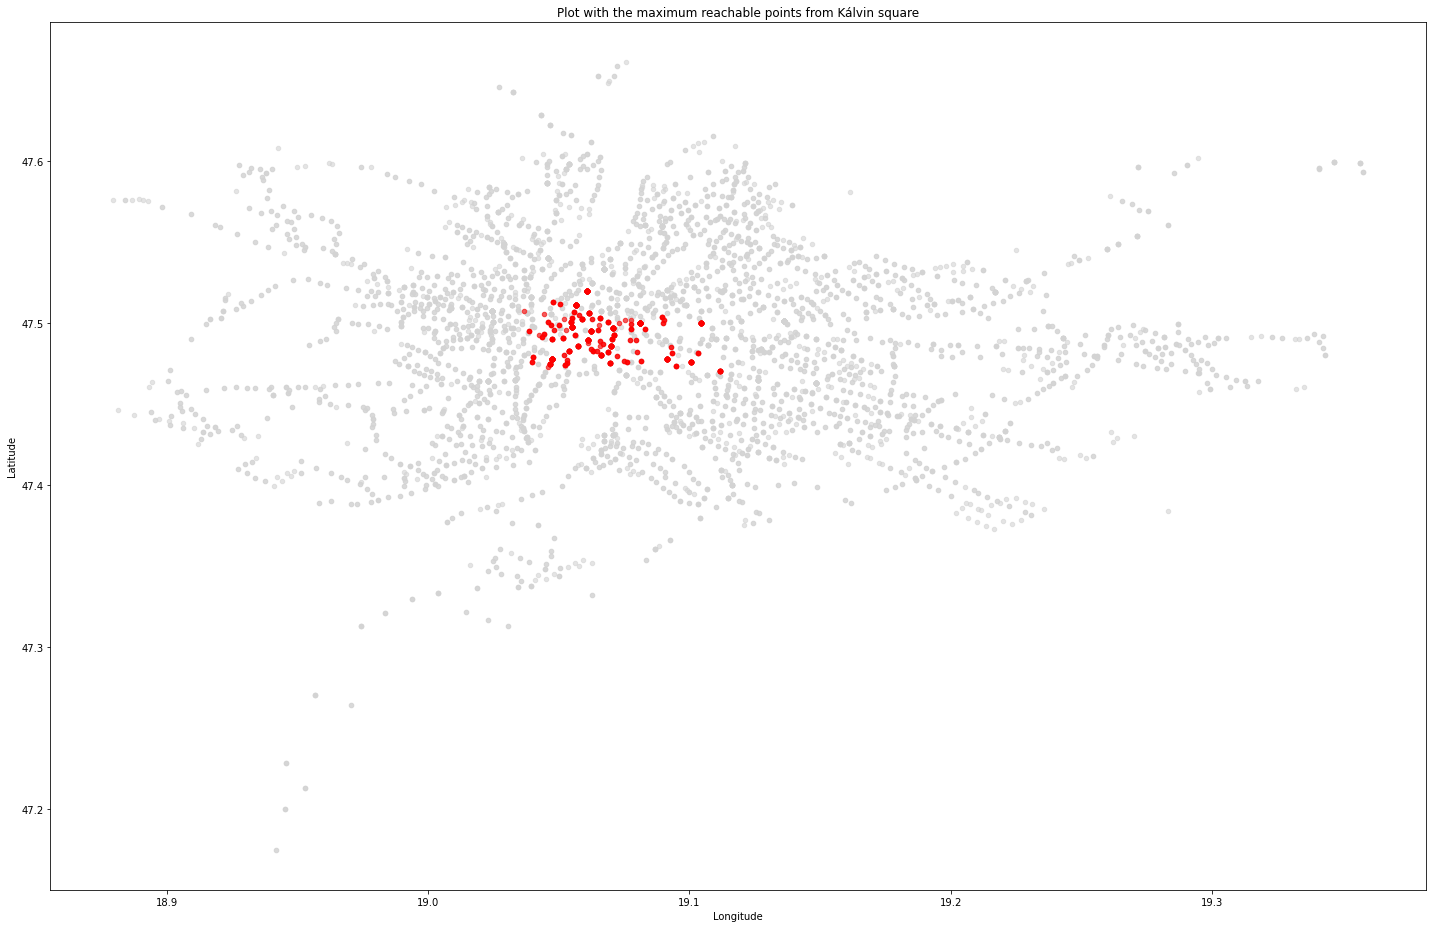

In [35]:
lon = kalvin_nodes['stop_lon']
lat = kalvin_nodes['stop_lat']


plt.figure(figsize=(20, 13))
plt.scatter(df['stop_lon'], df['stop_lat'], c='lightgray', s=20, alpha=0.6)  

plt.scatter(lon, lat, c='red', s=20, alpha=0.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot with the maximum reachable points from Kálvin square')
plt.grid(False) 
plt.tight_layout() 
plt.show()